In [1]:
%load_ext autoreload  
%autoreload 2 
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

In [3]:
data_path = "./petfinder-pawpularity-score"
df_train = pd.read_csv(f'{data_path}/train.csv')

In [4]:
train_img_paths = [f"{data_path}/train/{id}.jpg" for id in df_train["Id"].values]

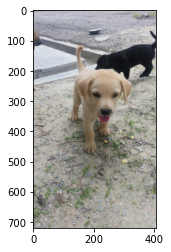

In [5]:
image = cv2.imread(train_img_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [6]:
class PawpularDataset: 
    def __init__(self, dense_features, targets, image_paths): 
        self.dense_features = dense_features
        self.targets = targets
        self.image_paths = image_paths

    def __getitem__(self, i):
        # get image
        image = cv2.imread(train_img_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return {
            "image": image,
            "dense_features": self.dense_features[i],
            "target": self.targets[i]
        }
        
        

In [7]:
dense_features = [
    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
]

train_ds = PawpularDataset(
    image_paths=train_img_paths,
    dense_features=df_train[dense_features].values,
    targets=df_train.Pawpularity.values,
)

In [10]:
def show_data_img(data):
    plt.figure()
    plt.imshow(data['image'])
    plt.figtext(0, 0, f"score: {data['target']}", fontsize = 10)

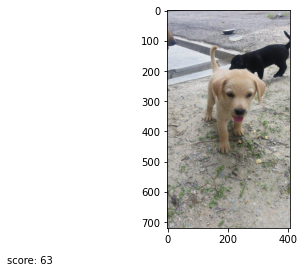

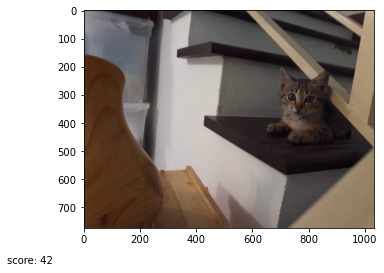

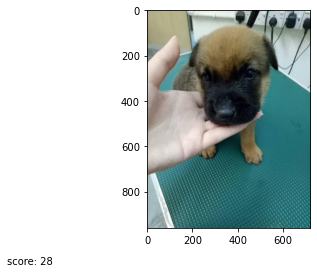

In [11]:
for i in range(3):
    show_data_img(train_ds[i])